In [11]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
%matplotlib inline

# Reading data

In [12]:
train_df = pd.read_csv('data/TrainData2.csv', delimiter = ',').dropna().reset_index(drop=True)
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'], format='%Y%m%d %H:%M')
train_df = train_df.set_index('TIMESTAMP')
std_dev = 3
train_df = train_df[(np.abs(stats.zscore(train_df)) < float(std_dev)).all(axis=1)]

In [13]:
pred_df = pd.read_csv('data/WeatherForecastInput2.csv', delimiter = ',')
pred_df['TIMESTAMP'] = pd.to_datetime(pred_df['TIMESTAMP'], format='%Y%m%d %H:%M')
pred_df = pred_df.set_index('TIMESTAMP')

In [14]:
result = pd.read_csv('data/Solution2.csv', delimiter = ',')
result['TIMESTAMP'] = pd.to_datetime(result['TIMESTAMP'], format='%Y%m%d %H:%M')
result = result.set_index('TIMESTAMP')

# Feature Engineering

In [15]:
X = pd.DataFrame()
X['U10'] = train_df['U10']
X['U100'] = train_df['U100']
X['V10'] = train_df['V10']
X['V100'] = train_df['V100']
X['U10^2'] = X['U10']**2
X['U100^2'] = X['U100']**2
#X['V10^2'] = X['V10']**2
#X['V100^2'] = X['V100']**2
#X['U10^3'] = X['U10']**3
#X['U100^3'] = X['U100']**3
X['V10^3'] = X['V10']**3
X['V100^3'] = X['V100']**3

X['W10'] = np.sqrt(train_df['U10']**2 + train_df['V10']**2)
X['W100'] = np.sqrt(train_df['U100']**2 + train_df['V100']**2)
X['W10^2'] = X['W10']**2
X['W100^2'] = X['W100']**2
X['W10^3'] = X['W10']**3
X['W100^3'] = X['W100']**3
X['beta_0'] = 1
X['hour'] = X.index.hour
X['year'] = X.index.year
X['month'] = X.index.month

y = train_df[['POWER']].copy()

X_pred = pd.DataFrame()

X_pred['U10'] = pred_df['U10']
X_pred['U100'] = pred_df['U100']
X_pred['V10'] = pred_df['V10']
X_pred['V100'] = pred_df['V100']
X_pred['U10^2'] = X_pred['U10']**2
X_pred['U100^2'] = X_pred['U100']**2
#X_pred['V10^2'] = X_pred['V10']**2
#X_pred['V100^2'] = X_pred['V100']**2
#X_pred['U10^3'] = X_pred['U10']**3
#X_pred['U100^3'] = X_pred['U100']**3
X_pred['V10^3'] = X_pred['V10']**3
X_pred['V100^3'] = X_pred['V100']**3

X_pred['W10'] = np.sqrt(pred_df['U10']**2 + pred_df['V10']**2)
X_pred['W100'] = np.sqrt(pred_df['U100']**2 + pred_df['V100']**2)
X_pred['W10^2'] = X_pred['W10']**2
X_pred['W100^2'] = X_pred['W100']**2
X_pred['W10^3'] = X_pred['W10']**3
X_pred['W100^3'] = X_pred['W100']**3

X_pred['beta_0'] = 1

X_pred['hour'] = X_pred.index.hour
X_pred['year'] = X_pred.index.year
X_pred['month'] = X_pred.index.month

# Model

In [16]:
model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X_pred).clip(min=0,max=1)
np.savetxt("stage2.csv", predictions, delimiter=",")

# Plots

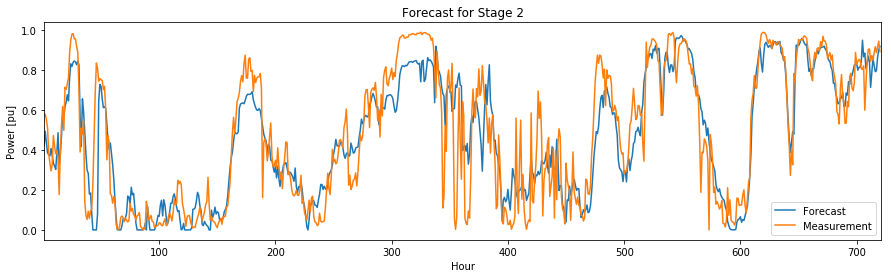

In [17]:
x = range(1,(len(predictions)+1))
y1 = predictions
y2 = result.values

plt.figure(figsize=(15,4))
plt.plot(x,y1)
plt.plot(x,y2)
ax = plt.gca()
ax.set_xlim(1,len(predictions)+1)
#ax.set_xticks(range(1,(len(predictions)+1)));
ax.set_ylabel('Power [pu]')
ax.set_xlabel('Hour')
ax.set_title('Forecast for Stage 2')
ax.legend(['Forecast','Measurement']);
plt.savefig('2.png', bbox_inches = 'tight')

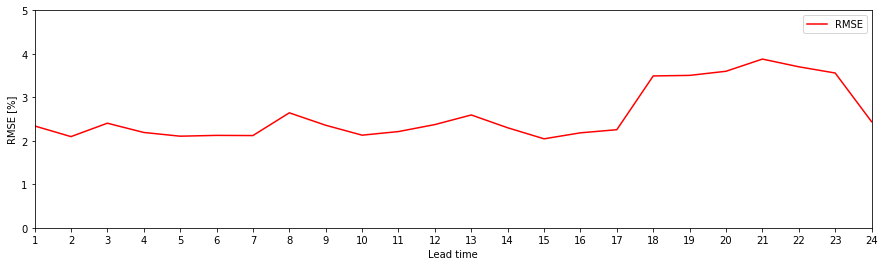

In [54]:
days = (result.index[-1] - result.index[0]).days + 1
rmse_h = result
rmse_h['pred'] = predictions
rmse_h['hour'] = rmse_h.index.hour
rmse_h['hour'] = rmse_h['hour'].replace(0,24)
rmse_h['sq-error'] = (rmse_h['POWER'] - rmse_h['pred'])**2
rmse_h = rmse_h.groupby('hour').sum().drop(columns=['POWER','pred'])
rmse_h['RMSE'] = (100*rmse_h['sq-error']**(1/2))/days

x = rmse_h.index
y1 = rmse_h['RMSE'].values

plt.figure(figsize=(15,4))
plt.plot(x,y1, color='red')
ax = plt.gca()
ax.set_xlim(1,24)
ax.set_ylim(0,5)
ax.set_xticks(range(1,25));
ax.set_ylabel('RMSE [%]')
ax.set_xlabel('Lead time')
#ax.set_title('Forecast for 01/01/2018')
ax.legend(['RMSE']);
plt.savefig('rmse_2.png', bbox_inches = 'tight')

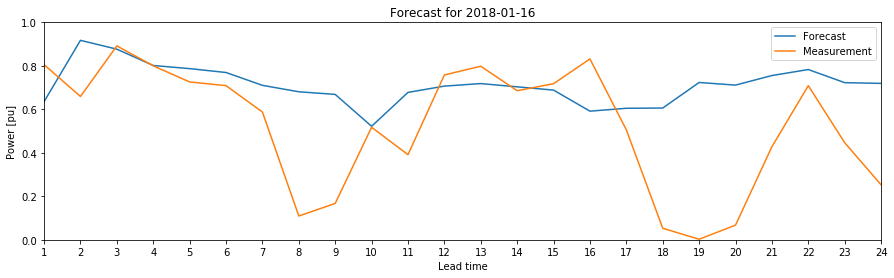

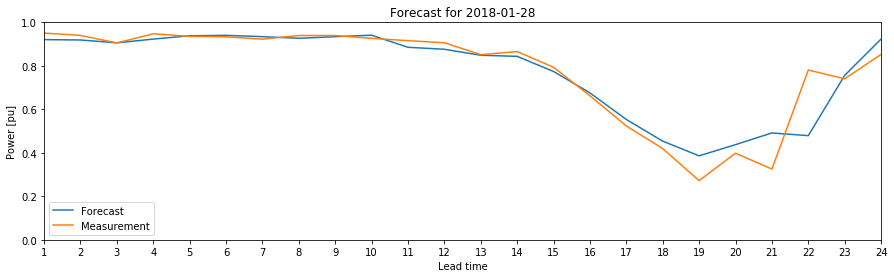

In [68]:
for day in [16,28]:
    
    y1 = result.loc['2018-01-{} 01:00:00'.format(day):'2018-01-{} 00:00:00'.format(day+1)]['pred'].values
    y2 = result.loc['2018-01-{} 01:00:00'.format(day):'2018-01-{} 00:00:00'.format(day+1)]['POWER'].values
    x = range(1,(len(y1)+1))

    plt.figure(figsize=(15,4))
    plt.plot(x,y1)
    plt.plot(x,y2)
    ax = plt.gca()
    ax.set_ylim(0,1)
    ax.set_xlim(1,24)
    ax.set_xticks(range(1,25));
    ax.set_ylabel('Power [pu]')
    ax.set_xlabel('Lead time')
    ax.set_title('Forecast for 2018-01-{}'.format(day))
    ax.legend(['Forecast','Measurement']);
    plt.savefig('day_{}.png'.format(day), bbox_inches = 'tight')